In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r'C:\Users\bless\OneDrive\Desktop\week 5\credit-risk-model\data\raw\data.csv')
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], errors='coerce')

In [3]:
snapshot_date = df['TransactionStartTime'].max() + pd.Timedelta(days=1)

In [4]:
rfm = df.groupby('CustomerId').agg({
    'TransactionStartTime': lambda x: (snapshot_date - x.max()).days,
    'TransactionId': 'count',
    'Amount': 'sum'
}).rename(columns={
    'TransactionStartTime': 'Recency',
    'TransactionId': 'Frequency',
    'Amount': 'Monetary'
}).reset_index()

rfm.head()

,CustomerId,Recency,Frequency,Monetary
0,CustomerId_1,84,1,-10000.0
1,CustomerId_10,84,1,-10000.0
2,CustomerId_1001,90,5,20000.0
3,CustomerId_1002,26,11,4225.0
4,CustomerId_1003,12,6,20000.0


In [5]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


In [6]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

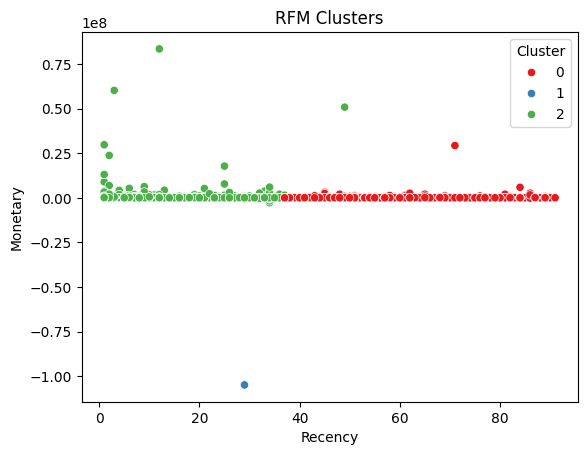

In [7]:
sns.scatterplot(x=rfm['Recency'], y=rfm['Monetary'], hue=rfm['Cluster'], palette='Set1')
plt.title('RFM Clusters')
plt.show()

In [8]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}: Recency={center[0]:.2f}, Frequency={center[1]:.2f}, Monetary={center[2]:.2f}")

Cluster 0: Recency=61.49, Frequency=7.65, Monetary=81663.57
Cluster 1: Recency=29.00, Frequency=4091.00, Monetary=-104900000.00
Cluster 2: Recency=12.50, Frequency=35.11, Monetary=274441.24


In [10]:
numeric_cols = ['Recency', 'Frequency', 'Monetary']
cluster_means = rfm.groupby('Cluster')[numeric_cols].mean()

In [12]:
high_risk_cluster = cluster_means['Recency'].idxmax()
print("Cluster Averages:\n", cluster_means)
print(f"\n💥 High-risk cluster identified: {high_risk_cluster}")

Cluster Averages:
            Recency    Frequency      Monetary
Cluster                                      
0        61.859846     7.726699  8.172379e+04
1        29.000000  4091.000000 -1.049000e+08
2        12.716076    34.807692  2.726546e+05

💥 High-risk cluster identified: 0


In [13]:
rfm['is_high_risk'] = (rfm['Cluster'] == high_risk_cluster).astype(int)
rfm[['CustomerId', 'is_high_risk']].head()


,CustomerId,is_high_risk
0,CustomerId_1,1
1,CustomerId_10,1
2,CustomerId_1001,1
3,CustomerId_1002,0
4,CustomerId_1003,0


In [16]:
final_df = pd.read_csv('../data/processed/final_features.csv')

In [17]:
final_df = final_df.merge(rfm[['CustomerId', 'is_high_risk']], on='CustomerId', how='left')
final_df['is_high_risk'] = final_df['is_high_risk'].fillna(0).astype(int)  # fill missing as low risk

final_df.head()

,CustomerId,total_amount,avg_amount,std_amount,transaction_count,fraud_count,ProductCategory,ChannelId,CurrencyCode,is_high_risk
0,CustomerId_1,-10000.0,-10000.000000,0.000000,1,0,airtime,ChannelId_2,UGX,1
1,CustomerId_10,-10000.0,-10000.000000,0.000000,1,0,airtime,ChannelId_2,UGX,1
2,CustomerId_1001,20000.0,4000.000000,6558.963333,5,0,airtime,ChannelId_3,UGX,1
3,CustomerId_1002,4225.0,384.090909,560.498966,11,0,financial_services,ChannelId_2,UGX,0
4,CustomerId_1003,20000.0,3333.333333,6030.478146,6,0,airtime,ChannelId_3,UGX,0
